## License

Copyright 2021 - 2025 Patrick Hall (jphall@gwu.edu) & N M Emran Hussain (nmemran.hussain@gwue.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 4 Template
With two calls to a blackbox prediction API we can craft adversarial examples to manipulate the model toward higher and lower predictions.

In [1]:
!pip install interpret h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 340.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# may need to be updated to location on your drive
%cd drive/My\ Drive/DNSC_6330_Software/assignments/
%ls

Mounted at /content/drive/
/content/drive/My Drive/DNSC_6330_Software/assignments
assign_3_template_s_78600.ipynb
assign_4_template.ipynb
Group_11_ebm_2025_04_01_19_20_48.csv
Group_11_ebm_n_models_50_2025_04_03_22_13_13.csv
Group_11_s_23456_2025_04_04_21_51_07.csv
Group11_s_309_2025_04_07_00_12_08.csv
Group11_s_78600_2025_04_06_20_55_10.csv


#### Imports and inits

In [3]:
import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpd80yjob5
  JVM stdout: /tmp/tmpd80yjob5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpd80yjob5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_u2e12q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Define Utility Functions

#### Utility function that trains a cross-validated decision tree

In [4]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    return tree

#### Start global timer

In [5]:
tic = time.time()

#### Import data

In [6]:
data = pd.read_csv('../data/hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [7]:
y_name = 'high_priced'

## Fit interpretable model

#### Split data into train and validation partitions

In [8]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [9]:
# params dict for remediated models
rem_params = {'max_bins': 512,
 'max_interaction_bins': 16,
 'interactions': 10,
 'outer_bags': 4,
 'inner_bags': 4,
 'learning_rate': 0.05,
 'validation_size': 0.5,
 'min_samples_leaf': 1,
 'max_leaves': 3,
 'n_jobs': 4,
 'early_stopping_rounds': 100,
 'random_state': 309}

rem_x_names = ['property_value_std',
 'conforming',
 'debt_to_income_ratio_missing',
 'income_std',
 'term_360',
 'no_intro_rate_period_std',
 'debt_to_income_ratio_std',
 'intro_rate_period_std']


# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7801.


## Model Extraction Attack

#### Generate synthetic data for extraction attack
For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [12]:
# best guess at feature distributions
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'conforming':                   {'p': 0.9, 'dist': 'binomial'},
               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},
               'debt_to_income_ratio_missing': {'p': 0.1, 'dist': 'binomial'},
               'loan_amount_std':              {'min': -5, 'scale': 10, 'dist': 'exponential'},
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame

np.random.seed(SEED) # same results each time cell is run

for j in list(schema_dict.keys()): # loop through features

    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'],
                                           size=N)

    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'],
                                                                        size=N)

    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std']

#### Visualize simulated data

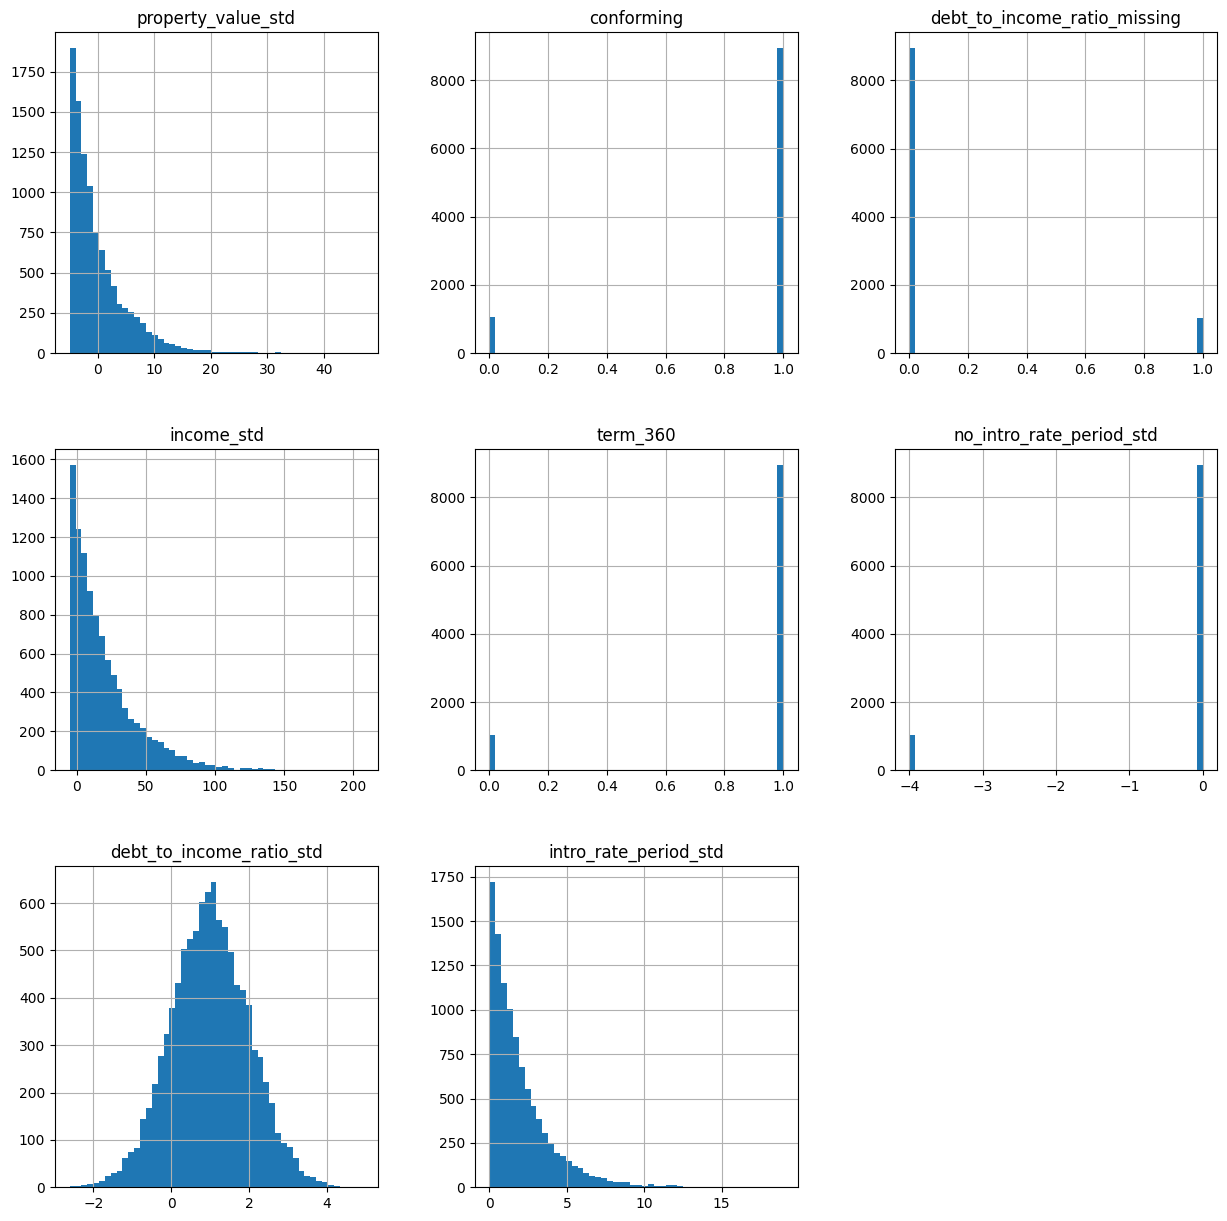

In [13]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### First call to blackbox model for predictions on random data

In [14]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat'])
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,term_360,conforming,no_intro_rate_period_std,debt_to_income_ratio_missing,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
0,0,1,0,0,5.090534,3.779215,-2.487803,6.340475,0.405221,0.021978
1,1,1,-4,1,0.149773,3.832138,-4.306141,28.624894,1.485471,0.193520
2,1,1,0,0,9.269409,5.559953,-1.258890,-1.387233,0.736794,0.139703
3,1,1,0,0,-3.755890,5.554915,-3.620824,5.981866,1.754882,0.004220
4,1,1,0,0,3.980574,1.098937,1.505871,-2.100684,0.871335,0.087502


#### Extract a stolen decision tree model

In [15]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt',
                      SEED,
                      'Stolen Model')

# convert h2o MOJO (stolen_dt.zip) into GraphViz file (stolen_dt.png)
!java -cp "/usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar" hex.genmodel.tools.PrintMojo --tree 0 -i "stolen_dt.zip" -o stolen_dt.gv --title "Stolen Model"

# convert Graphviz file into png
!dot -Tpng stolen_dt.gv -o stolen_dt.png

# three new files should appear:
# - stolen_dt.zip
# - stolen_dt.gv
# - stolen_dt.png
%ls

Generated MOJO path:
 /content/drive/My Drive/DNSC_6330_Software/assignments/stolen_dt.zip
assign_3_template_s_78600.ipynb
assign_4_template.ipynb
Group_11_ebm_2025_04_01_19_20_48.csv
Group_11_ebm_n_models_50_2025_04_03_22_13_13.csv
Group_11_s_23456_2025_04_04_21_51_07.csv
Group11_s_309_2025_04_07_00_12_08.csv
Group11_s_78600_2025_04_06_20_55_10.csv
stolen_dt.gv
stolen_dt.png
stolen_dt.zip


#### View stolen model
Double clicking should zoom.

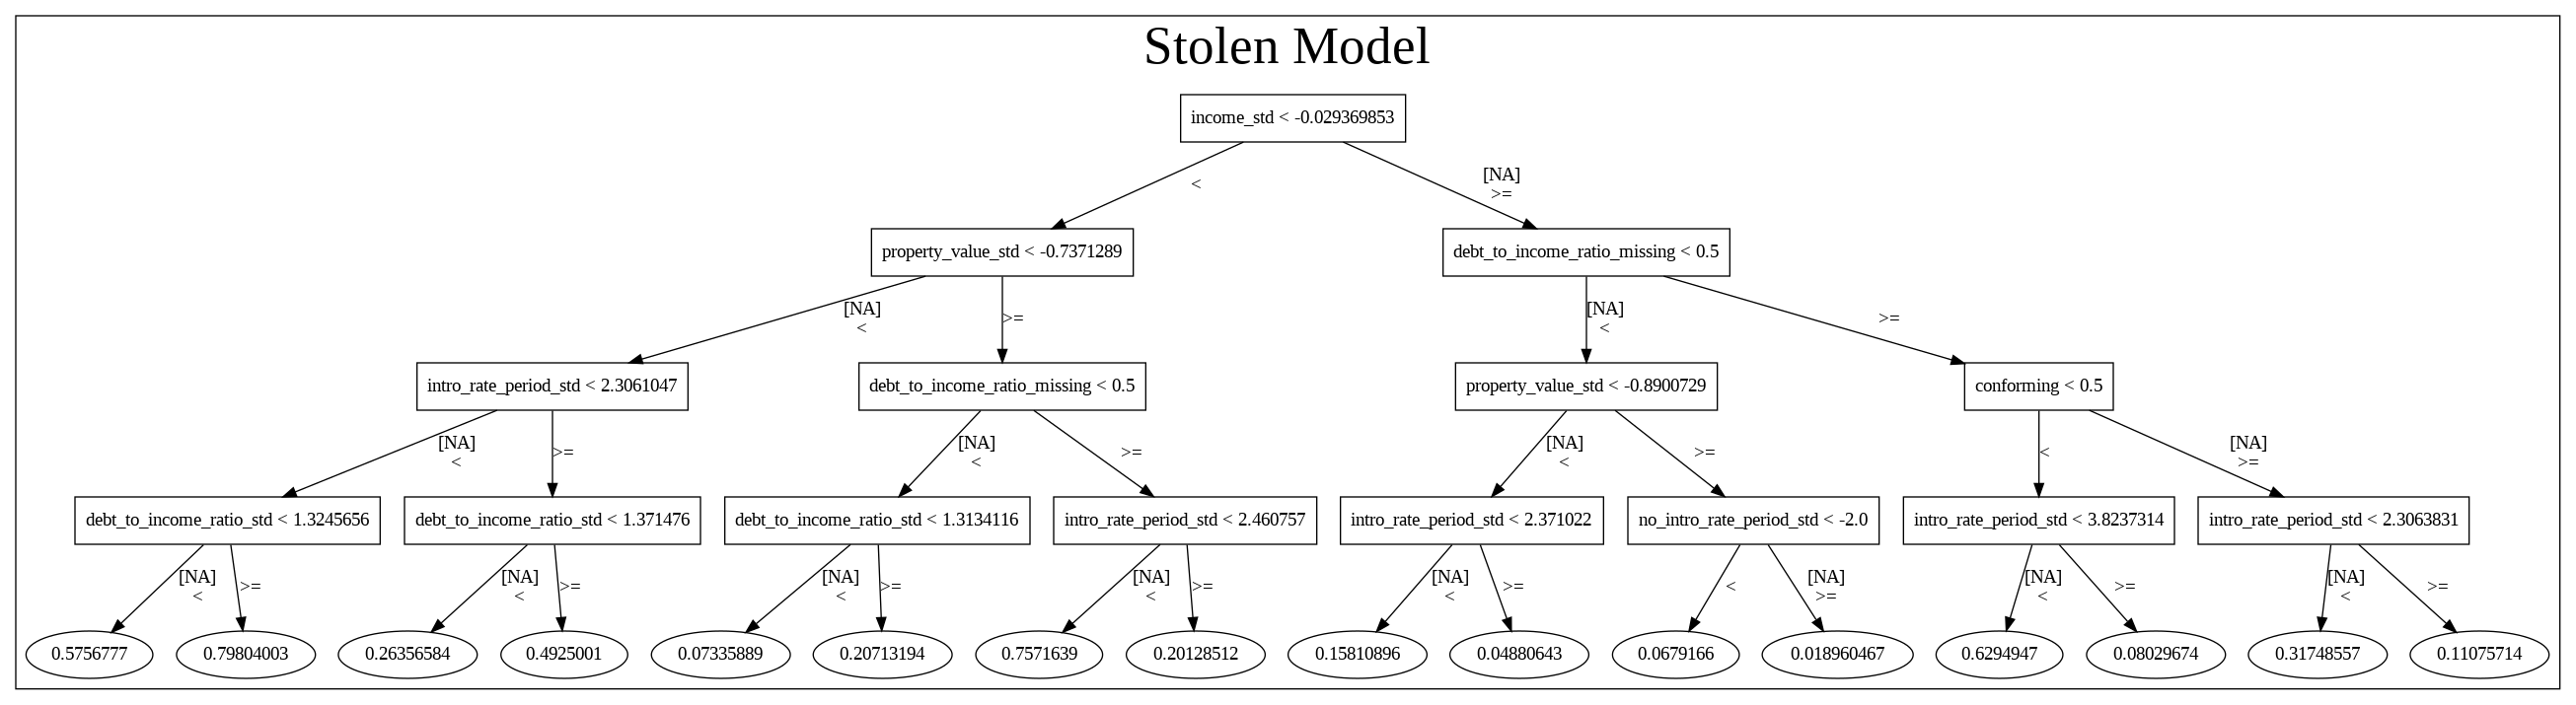

In [16]:
display(Image(('stolen_dt.png')))

Now an attacker has a basic flow chart for how the EBM works. This can be used as a sandbox for subsequent attacks!

#### Variable importance for stolen model

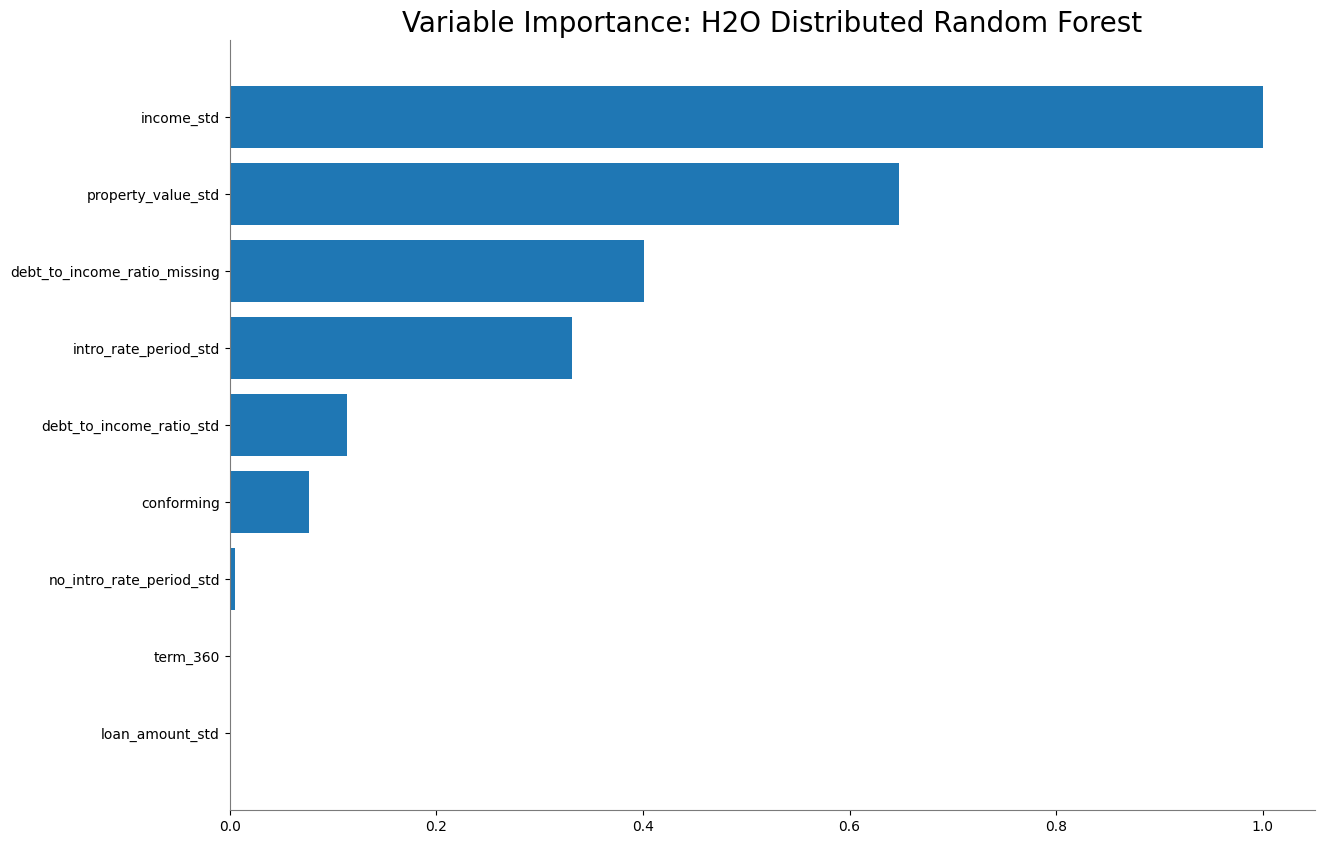

<Figure size 640x480 with 0 Axes>

In [17]:
stolen_dt.varimp_plot()

These are the most important variables in the stolen model, and likely in the real model too.

#### Assess accuracy of stolen model

In [18]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
aic,nan,0.0,nan,nan,nan
loglikelihood,nan,0.0,nan,nan,nan
mae,0.0576940,0.0007811,0.0578059,0.0568629,0.0584131
mean_residual_deviance,0.0091073,0.0005139,0.0092630,0.0085335,0.0095254
mse,0.0091073,0.0005139,0.0092630,0.0085335,0.0095254
r2,0.7870024,0.0092926,0.7829543,0.7976323,0.7804206
residual_deviance,0.0091073,0.0005139,0.0092630,0.0085335,0.0095254
rmse,0.0954065,0.0027095,0.0962444,0.0923771,0.0975980
rmsle,0.0723872,0.0017431,0.0727165,0.0705029,0.0739422


The stolen model is accurate enough (R2=0.79, RMSE=0.06), and importantly, very stable.

## Use Stolen Model to Craft Adversarial Examples

#### Use stolen model to find seed rows for adversary searches

In [28]:
low_adversary_seed = random_frame.loc[(random_frame['income_std'] >= -0.0293) &
                                      (random_frame['debt_to_income_ratio_missing'] < 0.5) &
                                      (random_frame['property_value_std'] >= -0.8900) &
                                      (random_frame['no_intro_rate_period_std'] >= -2.0), :].mean() # note this traces the stolen tree to the lowest prediction - does it trace your tree?

print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()


Low adversarial example search seed row:
term_360                         0.892819
conforming                       0.904492
no_intro_rate_period_std         0.000000
debt_to_income_ratio_missing     0.000000
loan_amount_std                  5.098024
intro_rate_period_std            2.055567
property_value_std               4.304437
income_std                      25.518897
debt_to_income_ratio_std         1.002541
dtype: float64



In [25]:
high_adversary_seed = random_frame.loc[(random_frame['income_std'] < -0.0293) &
                                       (random_frame['property_value_std'] < -0.7371) &
                                       (random_frame['intro_rate_period_std'] < 2.3061) &
                                       (random_frame['debt_to_income_ratio_std'] >= 1.3245), :].mean() # note this traces the stolen tree to the highest prediction - does it trace your tree?

print('High adversarial example search seed row:')
print(high_adversary_seed)

High adversarial example search seed row:
term_360                        0.901818
conforming                      0.861818
no_intro_rate_period_std       -0.392727
debt_to_income_ratio_missing    0.069091
loan_amount_std                 4.634915
intro_rate_period_std           0.943025
property_value_std             -3.186765
income_std                     -2.547453
debt_to_income_ratio_std        2.029279
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [31]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

# quantiles over which to search
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5]
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

idx = 0

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(high_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                for d in list(random_frame['term_360'].quantile(low_quantiles)):
                    low_adversary_seed_frame = pd.DataFrame(np.reshape(low_adversary_seed.values, (1, 9)), columns=list(schema_dict.keys()), index=[idx])
                    low_adversary_seed_frame['property_value_std'] = a
                    low_adversary_seed_frame['intro_rate_period_std'] = b
                    low_adversary_seed_frame['debt_to_income_ratio_std'] = c
                    low_adversary_seed_frame['term_360'] = d
                    low_adversary_frame = pd.concat([low_adversary_frame, low_adversary_seed_frame], axis=0)
                    idx += 1

# view potential low scoring adversarial examples
low_adversary_frame.head()

<ipython-input-31-db40e31a7262>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  low_adversary_frame = pd.concat([low_adversary_frame, low_adversary_seed_frame], axis=0)


,term_360,conforming,no_intro_rate_period_std,debt_to_income_ratio_missing,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0.0,0.904492,0.0,0.0,5.098024,9.418277,17.956808,25.518897,-1.362291
1,0.0,0.904492,0.0,0.0,5.098024,9.418277,17.956808,25.518897,-1.362291
2,0.0,0.904492,0.0,0.0,5.098024,9.418277,17.956808,25.518897,-1.362291
3,1.0,0.904492,0.0,0.0,5.098024,9.418277,17.956808,25.518897,-1.362291
4,1.0,0.904492,0.0,0.0,5.098024,9.418277,17.956808,25.518897,-1.362291


#### Perturb seed row to find high scoring adversarial examples

In [32]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

idx = 0

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(low_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                for d in list(random_frame['term_360'].quantile(high_quantiles)):
                    high_adversary_seed_frame = pd.DataFrame(np.reshape(high_adversary_seed.values, (1, 9)), columns=list(schema_dict.keys()), index=[idx])
                    high_adversary_seed['property_value_std'] = a
                    high_adversary_seed['intro_rate_period_std'] = b
                    high_adversary_seed['debt_to_income_ratio_std'] = c
                    high_adversary_seed['term_360'] = d
                    high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)
                    idx += 1

# view potential high scoring adversarial examples
high_adversary_frame.head()

<ipython-input-32-207379f6aa02>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)


,term_360,conforming,no_intro_rate_period_std,debt_to_income_ratio_missing,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,1.0,0.861818,-0.392727,0.069091,4.634915,0.021239,-4.946988,-2.547453,3.338354
1,1.0,0.861818,-0.392727,0.069091,4.634915,0.021239,-4.946988,-2.547453,3.338354
2,1.0,0.861818,-0.392727,0.069091,4.634915,0.021239,-4.946988,-2.547453,3.338354
3,1.0,0.861818,-0.392727,0.069091,4.634915,0.021239,-4.946988,-2.547453,3.338354
4,1.0,0.861818,-0.392727,0.069091,4.634915,0.021239,-4.946988,-2.547453,3.338354


#### Second call to blackbox API to test adversarial examples

In [33]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,term_360,conforming,no_intro_rate_period_std,debt_to_income_ratio_missing,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
5,0.0,0.904492,0.000000,0.000000,5.098024,9.418277,17.956808,25.518897,-0.633558,0.000001
6,0.0,0.904492,0.000000,0.000000,5.098024,9.418277,17.956808,25.518897,-0.633558,0.000001
7,0.0,0.904492,0.000000,0.000000,5.098024,9.418277,17.956808,25.518897,-0.633558,0.000001
31,0.0,0.904492,0.000000,0.000000,5.098024,6.004462,17.956808,25.518897,-0.633558,0.000001
30,0.0,0.904492,0.000000,0.000000,5.098024,6.004462,17.956808,25.518897,-0.633558,0.000001
...,...,...,...,...,...,...,...,...,...,...
744,1.0,0.861818,-0.392727,0.069091,4.634915,1.404889,-4.946988,-2.547453,1.672559,0.851183
1241,1.0,0.861818,-0.392727,0.069091,4.634915,1.404889,-1.587323,-2.547453,1.672559,0.851183
1242,1.0,0.861818,-0.392727,0.069091,4.634915,1.404889,-1.587323,-2.547453,1.672559,0.851183
1243,1.0,0.861818,-0.392727,0.069091,4.634915,1.404889,-1.587323,-2.547453,1.672559,0.851183


We now have many adversarial examples that can reliably evoke extremely low and high enough predictions from the blackbox API. These can most easily be used to falsify a loan application to recieve a low-priced loan (using low adversaries). Or they could be used to ensure someone else recievces a high-priced loan.

#### End timer

In [34]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 2439.73 s.


#### Shutdown H2O

In [35]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_9c02 closed.
